In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from scipy import ndimage

In [11]:
# Parameters to be tuned in different functions
LOW_THRESHOLD_RATIO = 0.09
HIGH_THRESHOLD_RATIO = 0.25
WEAK_PIXEL = 100
STRONG_PIXEL = 300

SAMPLE_IMAGE = "CTU2.jpg"

In [12]:
# A few utility functions to preprocess and visualize the results
def rgb2gray(rgb):
    """
        Converts an RGB image into grayscale
    """
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


def visualize(imgs, m, n):
    """
        Visualize images with the matplotlib library
    """
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(m, n, plt_idx)
        plt.imshow(img, cmap='gray')
    plt.show()

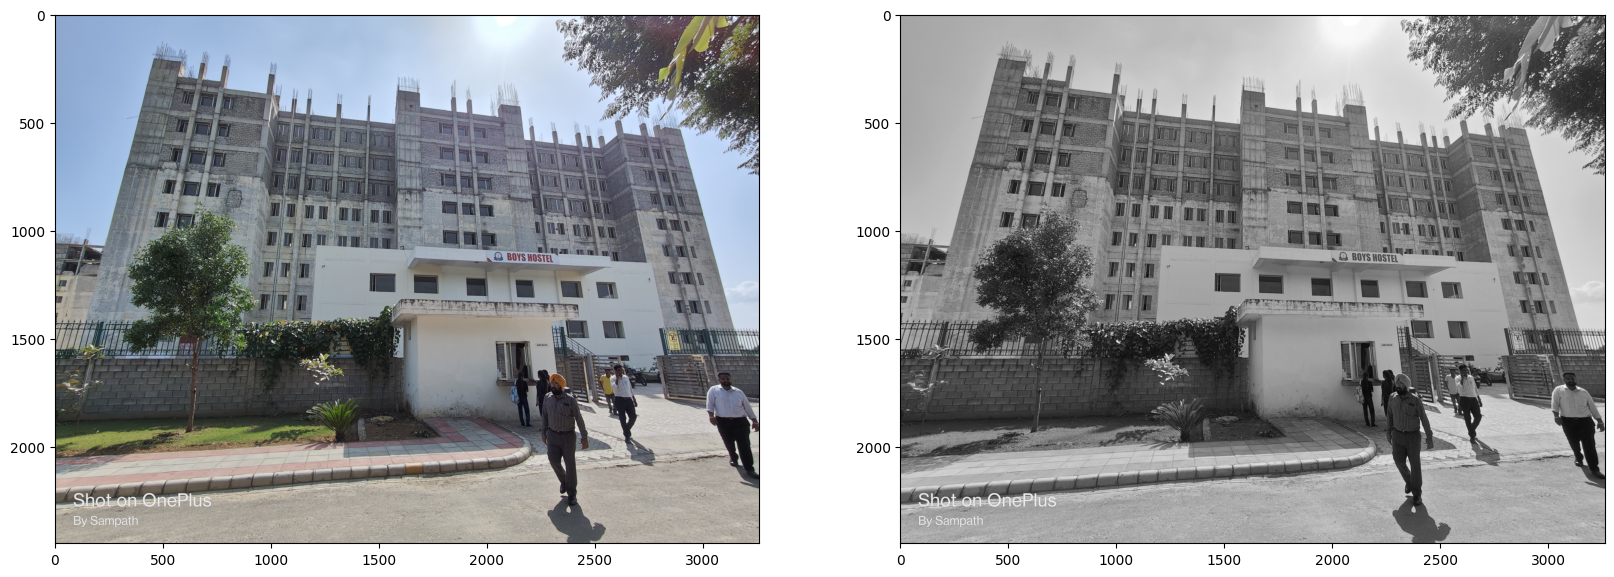

In [13]:
image = mpimg.imread(SAMPLE_IMAGE)
gray_image = rgb2gray(image)
img_list = [image, gray_image]

visualize(img_list, 1, 2)

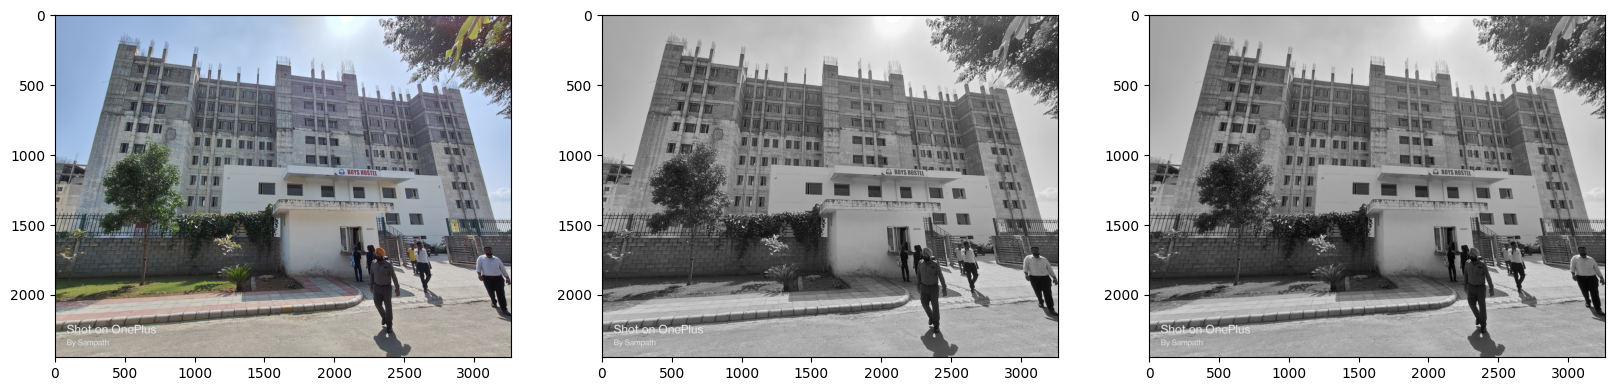

In [14]:
# Step 1: Noise Reduction
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
image_blurred = ndimage.convolve(gray_image, gaussian_kernel(5, 1.4))
img_list.append(image_blurred)

visualize(img_list, 1, 3)

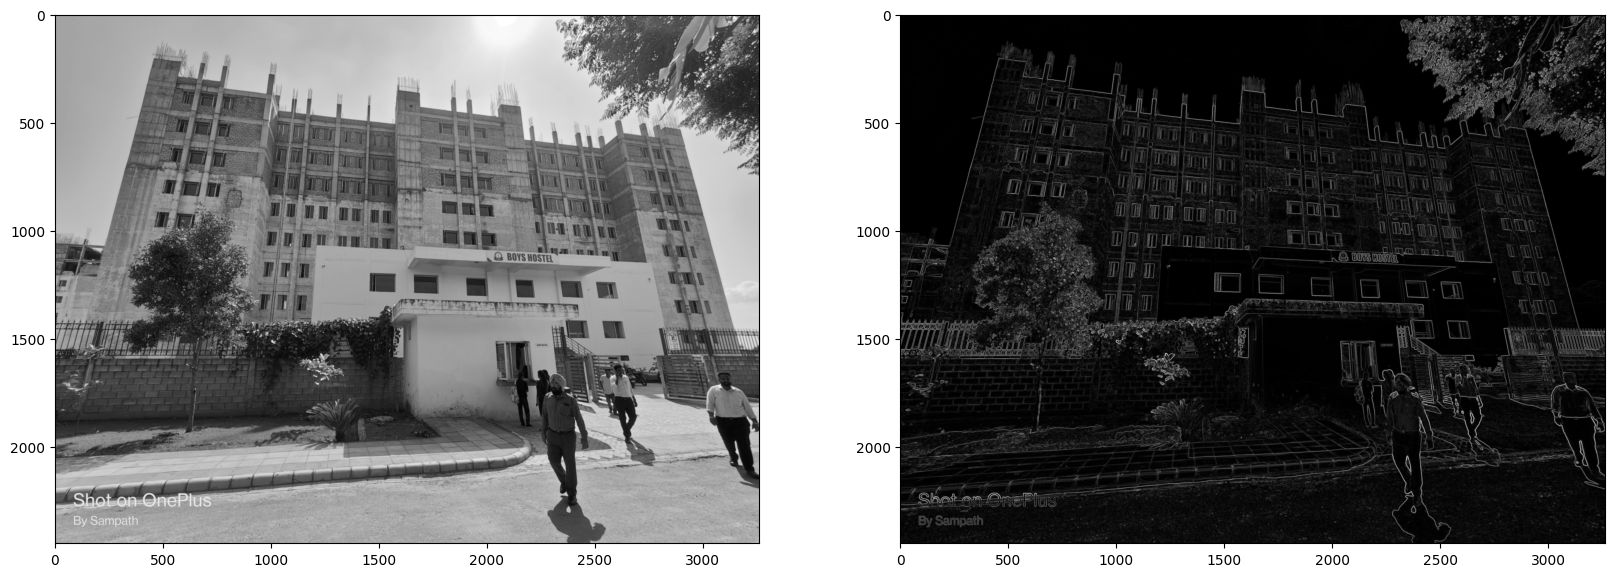

In [15]:
# Step 2: Gradient calculation
def sobel_filters(img):
    Kx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]], dtype=np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)

    return (G, theta)
gradientMat, thetaMat = sobel_filters(image_blurred)

visualize([image_blurred, gradientMat], 1, 2)

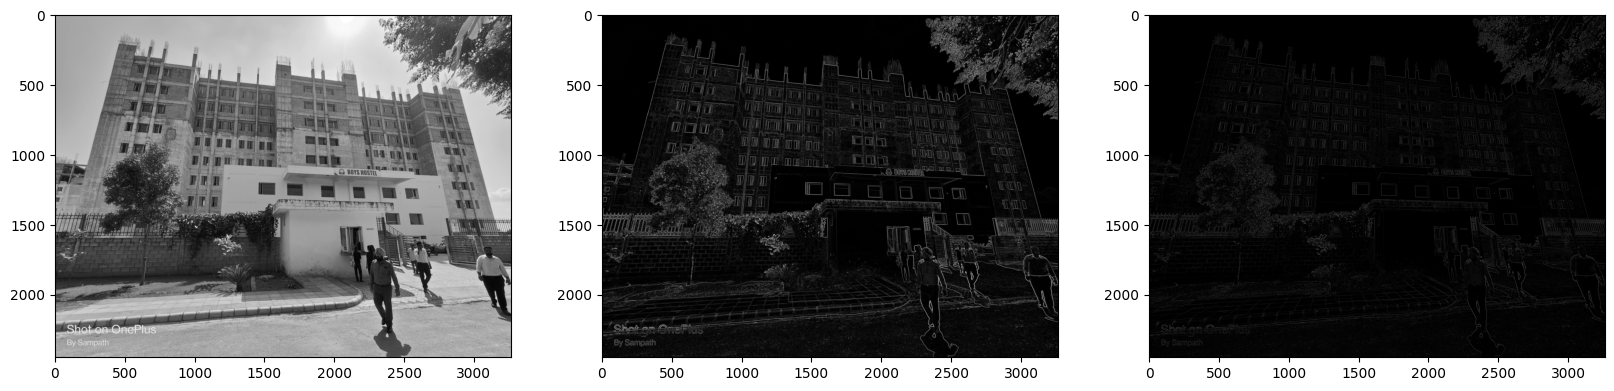

In [16]:
# Step 3: Non-maximum suppression
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M):
        for j in range(1, N):
            try:
                q = 300
                r = 300

               # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass
    return Z
non_max_img = non_max_suppression(gradientMat, thetaMat)
visualize([image_blurred, gradientMat, non_max_img], 1, 3)

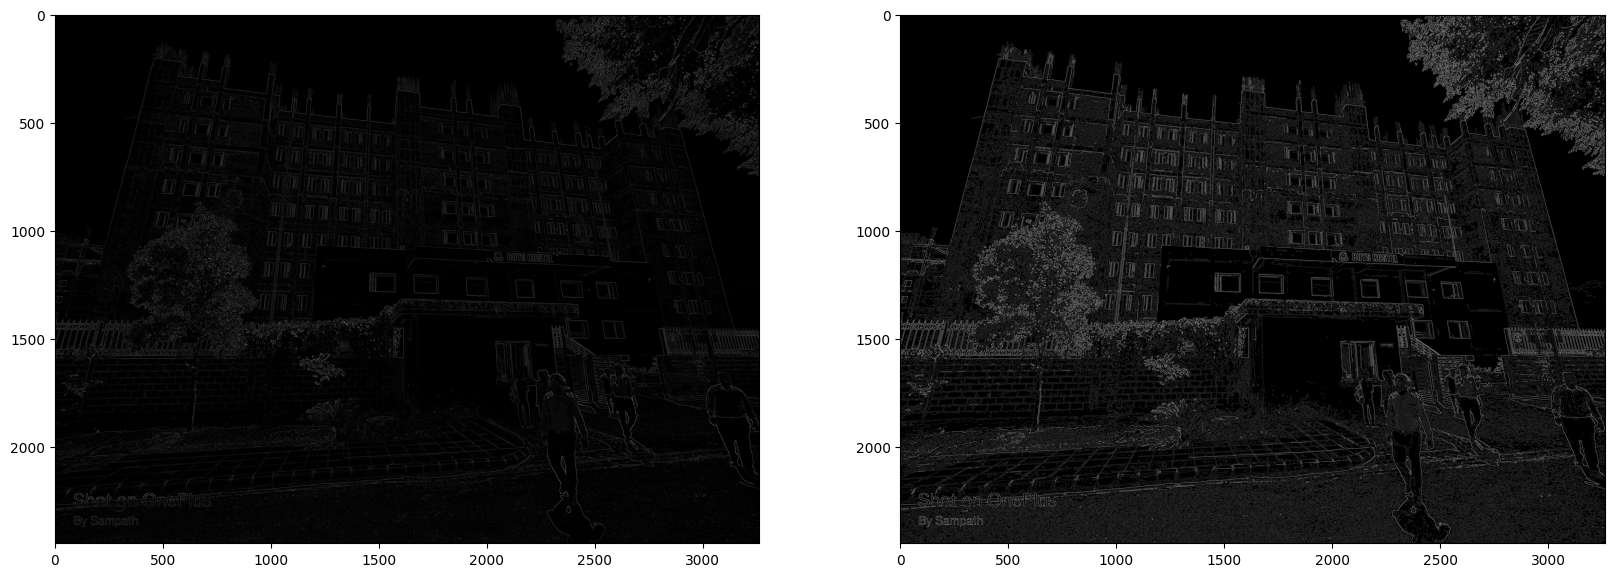

In [17]:
# Step 4: Double threshold
def threshold(img):
    hiThresh = img.max()*HIGH_THRESHOLD_RATIO
    loThresh = hiThresh * LOW_THRESHOLD_RATIO

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong_i, strong_j = np.where(img >= hiThresh)

    weak_i, weak_j = np.where((img >= loThresh) & (img <= hiThresh))

    res[strong_i, strong_j] = STRONG_PIXEL
    res[weak_i, weak_j] = WEAK_PIXEL

    return res
image_thresh = threshold(non_max_img)

visualize([non_max_img, image_thresh], 1, 2)

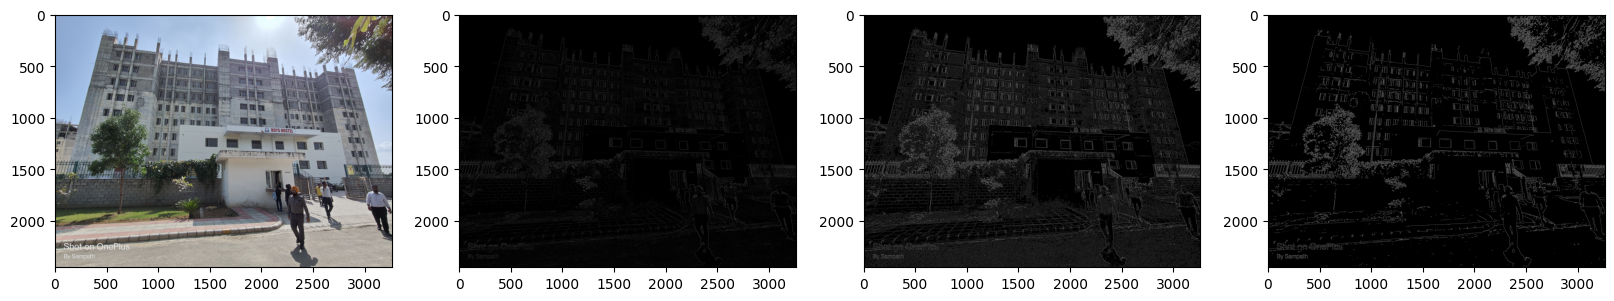

In [18]:
# Step 5: Edge Tracking by Hysteresis
def hysteresis(img):
    M, N = img.shape

    res = np.copy(img)

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == WEAK_PIXEL):
                try:
                    if (img[i+1, j-1] == STRONG_PIXEL) or (img[i+1, j] == STRONG_PIXEL) or (img[i+1, j+1] == STRONG_PIXEL) or (img[i, j-1] == STRONG_PIXEL) or (img[i, j+1] == STRONG_PIXEL) or (img[i-1, j-1] == STRONG_PIXEL) or (img[i-1, j] == STRONG_PIXEL) or (img[i-1, j+1] == STRONG_PIXEL):
                        res[i, j] = STRONG_PIXEL
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res
canny_image = hysteresis(image_thresh)
visualize([image, non_max_img, image_thresh, canny_image], 1, 4)